In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
epochs = 50
latent_dim = 20
num_classes = 10

In [ ]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Conditional VAE Model
class CVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder - takes both image and label
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder - takes both latent vector and label
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def encode(self, x, y):
        # Concatenate image and one-hot encoded label
        x = torch.cat([x, y], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, y):
        # Concatenate latent vector and one-hot encoded label
        z = torch.cat([z, y], dim=1)
        return self.decoder(z)
    
    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 784), y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

In [ ]:
# Utility function to one-hot encode labels
def one_hot(labels, num_classes):
    """Convert labels to one-hot vectors"""
    return F.one_hot(labels, num_classes).float()

# Loss function (same as VAE)
def cvae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD, BCE, KLD

In [ ]:
# Initialize model, optimizer
model = CVAE(latent_dim=latent_dim, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_bce = 0
    train_kld = 0
    
    for batch_idx, (data, labels) in enumerate(dataloader):
        data = data.to(device)
        labels_onehot = one_hot(labels, num_classes).to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_onehot)
        loss, bce, kld = cvae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} '
                  f'({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(dataloader.dataset)
    avg_bce = train_bce / len(dataloader.dataset)
    avg_kld = train_kld / len(dataloader.dataset)
    
    return avg_loss, avg_bce, avg_kld

Using device: cpu
Starting CVAE training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 543.491211
Train Epoch: 1 [12800/60000 (21%)]	Loss: 192.835739
Train Epoch: 1 [25600/60000 (43%)]	Loss: 156.461960
Train Epoch: 1 [38400/60000 (64%)]	Loss: 141.538956
Train Epoch: 1 [51200/60000 (85%)]	Loss: 133.206497
====> Test set loss: 130.2194, BCE: 117.5341, KLD: 12.6853
Epoch 1: Train Loss: 167.1244, Test Loss: 130.2194
Train Epoch: 2 [0/60000 (0%)]	Loss: 132.171814
Train Epoch: 2 [12800/60000 (21%)]	Loss: 134.281082
Train Epoch: 2 [25600/60000 (43%)]	Loss: 116.323524
Train Epoch: 2 [38400/60000 (64%)]	Loss: 118.966545
Train Epoch: 2 [51200/60000 (85%)]	Loss: 116.370430
====> Test set loss: 115.5191, BCE: 101.3003, KLD: 14.2188
Epoch 2: Train Loss: 122.7110, Test Loss: 115.5191
Train Epoch: 3 [0/60000 (0%)]	Loss: 112.519028
Train Epoch: 3 [12800/60000 (21%)]	Loss: 110.900681
Train Epoch: 3 [25600/60000 (43%)]	Loss: 109.841286
Train Epoch: 3 [38400/60000 (64%)]	Loss: 114.178543
Train Epoch: 3 [51200/6

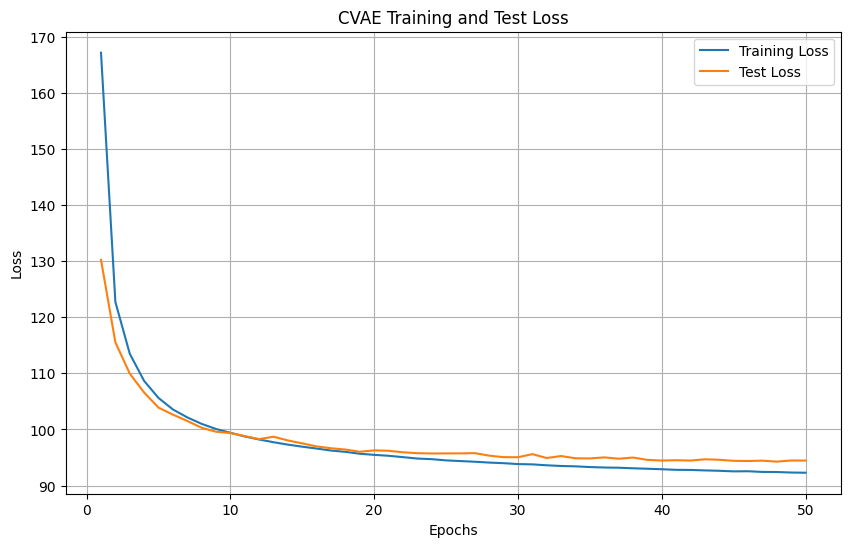


CVAE DEMONSTRATION

1. Showing reconstructions of test images...


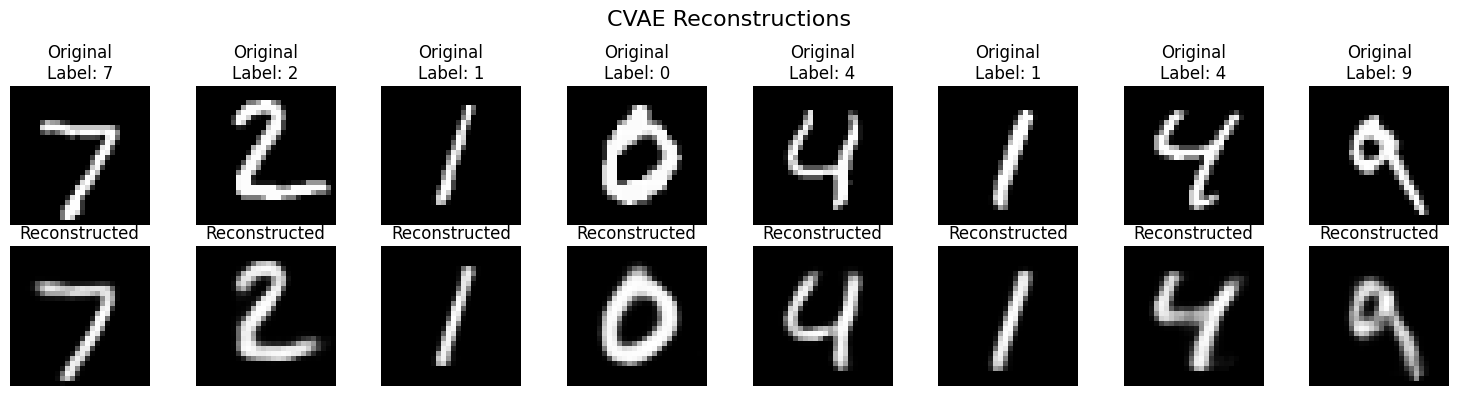


2. Demonstrating conditional generation (same noise, different labels)...


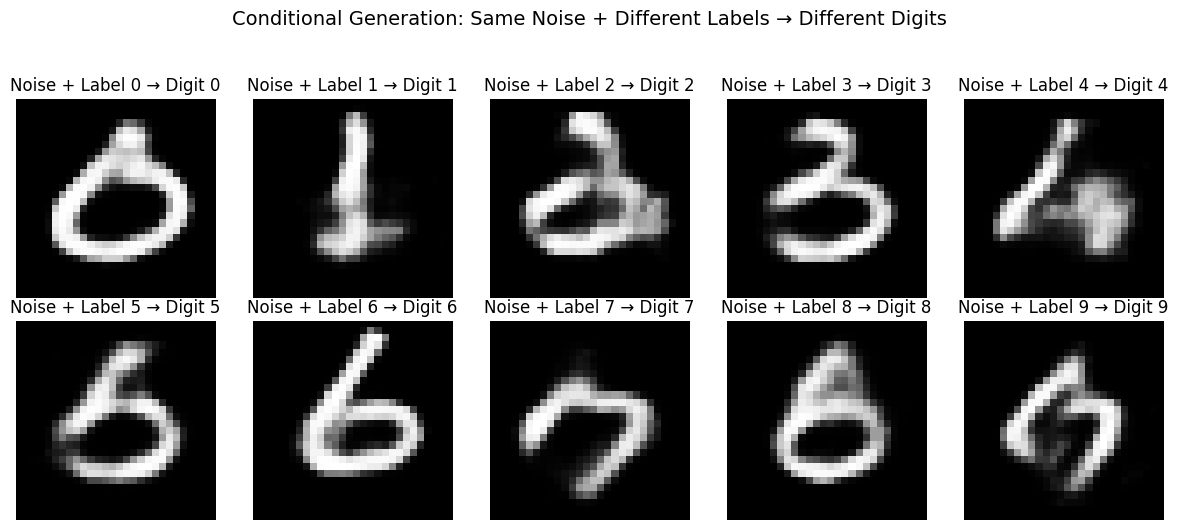


3. Generating images for all digits 0-9...


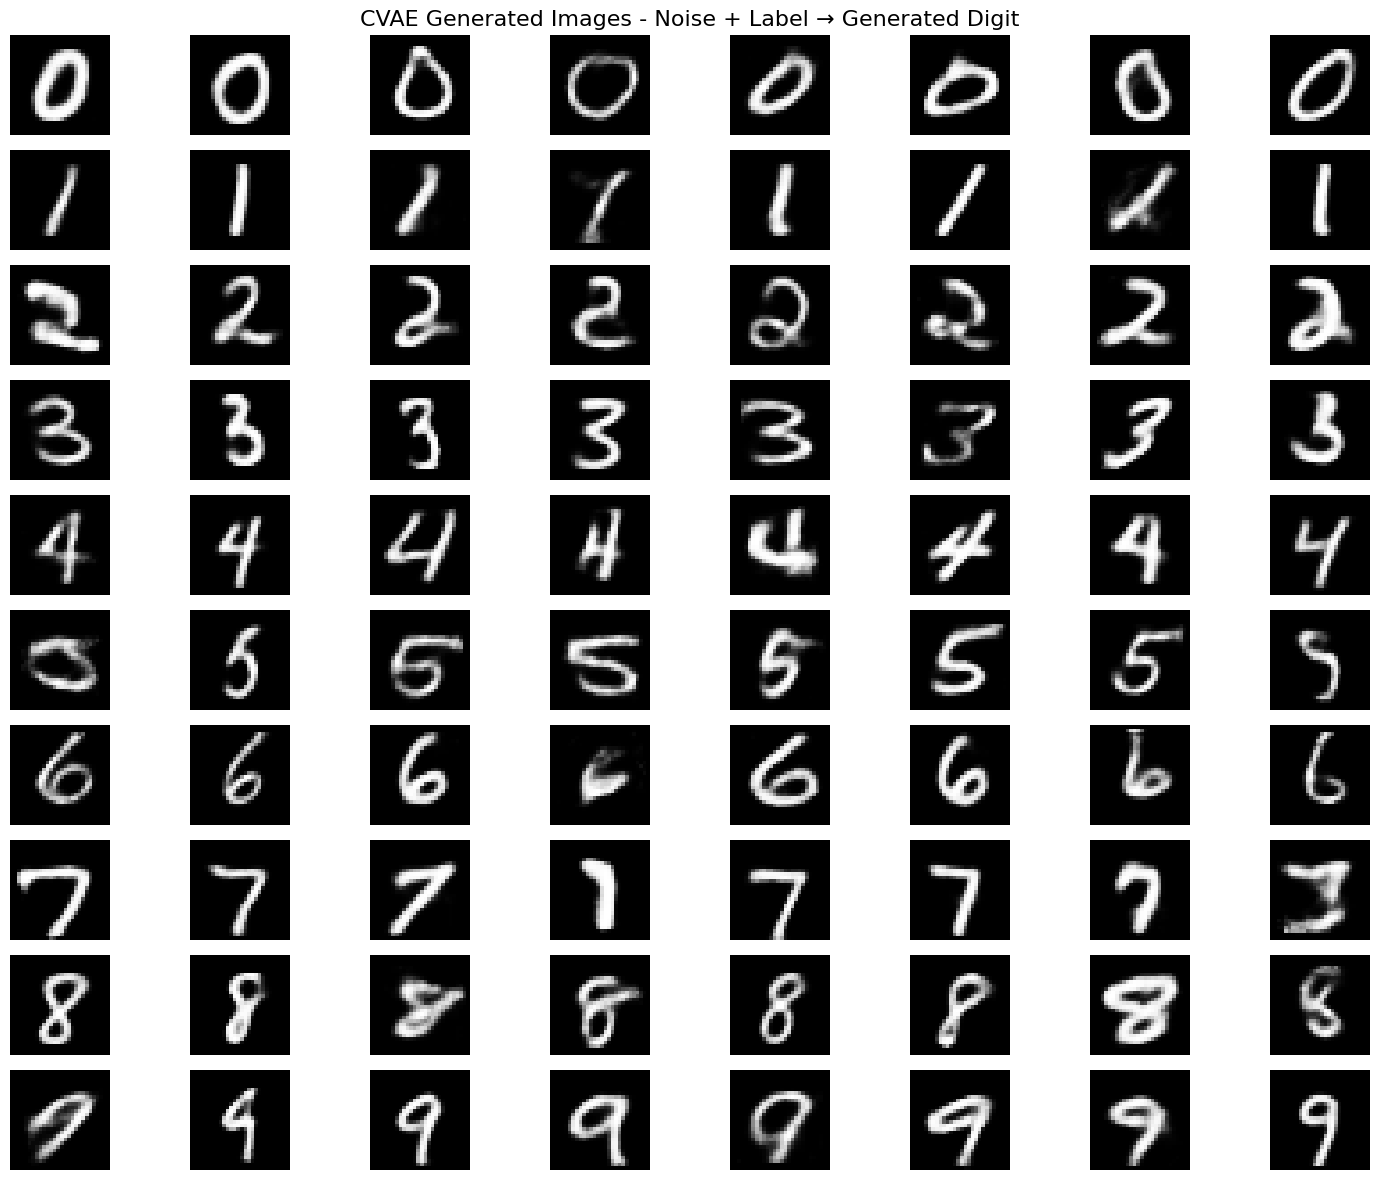


4. Demonstrating latent space interpolation...


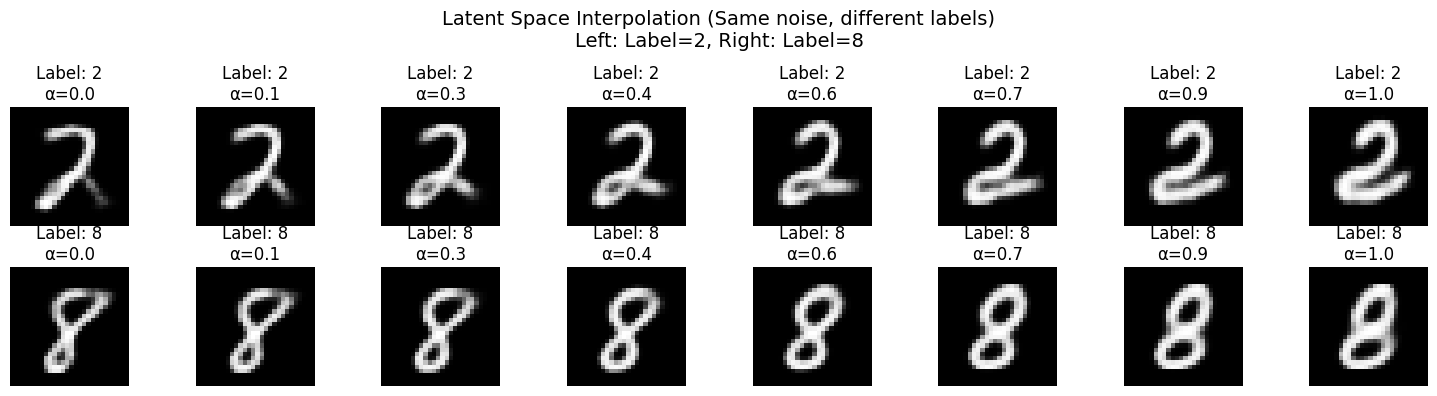

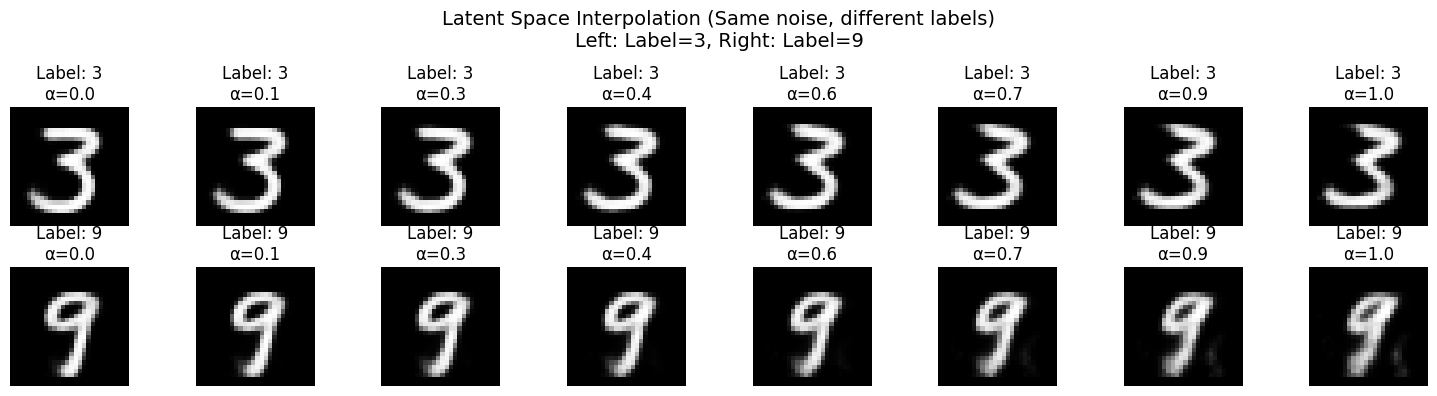


5. Generating specific digits...
Generating digit 0...


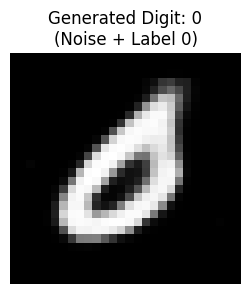

Generating digit 1...


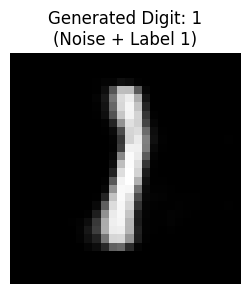

Generating digit 4...


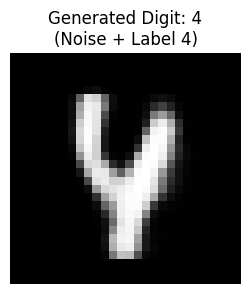

Generating digit 7...


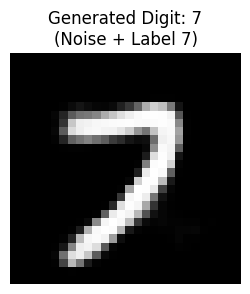

Generating digit 9...


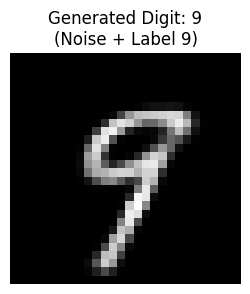


Model saved as 'cvae_mnist.pth'


In [ ]:
# Test function
def test(model, dataloader):
    model.eval()
    test_loss = 0
    test_bce = 0
    test_kld = 0
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels_onehot = one_hot(labels, num_classes).to(device)
            
            recon_batch, mu, logvar = model(data, labels_onehot)
            loss, bce, kld = cvae_loss(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            test_bce += bce.item()
            test_kld += kld.item()
    
    avg_loss = test_loss / len(dataloader.dataset)
    avg_bce = test_bce / len(dataloader.dataset)
    avg_kld = test_kld / len(dataloader.dataset)
    
    print(f'====> Test set loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')
    return avg_loss, avg_bce, avg_kld

# Training loop
print("Starting CVAE training...")
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_loss, train_bce, train_kld = train(model, train_loader, optimizer, epoch)
    test_loss, test_bce, test_kld = test(model, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Function to generate images using decoder with specific labels
def generate_images(model, digit_to_generate, num_images=10):
    """
    Generate images of a specific digit using the decoder
    """
    model.eval()
    with torch.no_grad():
        # Create random noise
        z = torch.randn(num_images, model.latent_dim).to(device)
        
        # Create one-hot labels for the desired digit
        labels = torch.tensor([digit_to_generate] * num_images).to(device)
        labels_onehot = one_hot(labels, num_classes).to(device)
        
        # Generate images using decoder
        generated_images = model.decode(z, labels_onehot)
        generated_images = generated_images.cpu().view(-1, 28, 28)
        
        return generated_images

# Function to show grid of generated images for all digits
def show_generated_grid(model, num_samples=10):
    """
    Generate and display a grid of images for all digits 0-9
    """
    model.eval()
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 12))
    
    with torch.no_grad():
        for digit in range(num_classes):
            # Generate images for this digit
            z = torch.randn(num_samples, model.latent_dim).to(device)
            labels = torch.tensor([digit] * num_samples).to(device)
            labels_onehot = one_hot(labels, num_classes).to(device)
            
            generated_images = model.decode(z, labels_onehot)
            generated_images = generated_images.cpu().view(-1, 28, 28)
            
            for sample in range(num_samples):
                axes[digit, sample].imshow(generated_images[sample], cmap='gray')
                axes[digit, sample].axis('off')
                
                if sample == 0:
                    axes[digit, sample].set_ylabel(f'Digit {digit}', rotation=90, size=12)
    
    plt.suptitle('CVAE Generated Images - Noise + Label → Generated Digit', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to show interpolation between digits
def show_interpolation(model, digit1, digit2, num_steps=10):
    """
    Show interpolation between two digits in latent space
    """
    model.eval()
    with torch.no_grad():
        # Generate two random latent vectors
        z1 = torch.randn(1, model.latent_dim).to(device)
        z2 = torch.randn(1, model.latent_dim).to(device)
        
        # Create interpolation in latent space
        alphas = torch.linspace(0, 1, num_steps)
        
        fig, axes = plt.subplots(2, num_steps, figsize=(15, 4))
        
        for i, alpha in enumerate(alphas):
            # Interpolate latent vectors
            z = alpha * z1 + (1 - alpha) * z2
            
            # Generate image with digit1 label
            label1 = torch.tensor([digit1]).to(device)
            label1_onehot = one_hot(label1, num_classes).to(device)
            img1 = model.decode(z, label1_onehot).cpu().view(28, 28)
            
            # Generate image with digit2 label
            label2 = torch.tensor([digit2]).to(device)
            label2_onehot = one_hot(label2, num_classes).to(device)
            img2 = model.decode(z, label2_onehot).cpu().view(28, 28)
            
            axes[0, i].imshow(img1, cmap='gray')
            axes[0, i].set_title(f'Label: {digit1}\nα={alpha:.1f}')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(img2, cmap='gray')
            axes[1, i].set_title(f'Label: {digit2}\nα={alpha:.1f}')
            axes[1, i].axis('off')
        
        plt.suptitle(f'Latent Space Interpolation (Same noise, different labels)\n'
                    f'Left: Label={digit1}, Right: Label={digit2}', fontsize=14)
        plt.tight_layout()
        plt.show()

# Function to demonstrate conditional generation with same noise
def show_conditional_generation(model):
    """
    Show how the same noise with different labels generates different digits
    """
    model.eval()
    with torch.no_grad():
        # Use the same noise for all digits
        z = torch.randn(1, model.latent_dim).to(device)
        z = z.repeat(num_classes, 1)  # Repeat for all digits
        
        # Create labels for all digits
        labels = torch.arange(0, num_classes).to(device)
        labels_onehot = one_hot(labels, num_classes).to(device)
        
        # Generate images
        generated_images = model.decode(z, labels_onehot)
        generated_images = generated_images.cpu().view(-1, 28, 28)
        
        # Plot
        fig, axes = plt.subplots(2, 5, figsize=(12, 5))
        axes = axes.ravel()
        
        for i in range(num_classes):
            axes[i].imshow(generated_images[i], cmap='gray')
            axes[i].set_title(f'Noise + Label {i} → Digit {i}')
            axes[i].axis('off')
        
        plt.suptitle('Conditional Generation: Same Noise + Different Labels → Different Digits', 
                    fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()

# Function to show reconstruction quality
def show_reconstructions(model, dataloader):
    """
    Show original and reconstructed images
    """
    model.eval()
    with torch.no_grad():
        data, labels = next(iter(dataloader))
        data = data[:8].to(device)
        labels_onehot = one_hot(labels[:8], num_classes).to(device)
        
        recon_data, _, _ = model(data, labels_onehot)
        recon_data = recon_data.cpu().view(-1, 28, 28)
        data = data.cpu()
        
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        
        for i in range(8):
            # Original
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original\nLabel: {labels[i].item()}')
            axes[0, i].axis('off')
            
            # Reconstructed
            axes[1, i].imshow(recon_data[i], cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.suptitle('CVAE Reconstructions', fontsize=16)
        plt.tight_layout()
        plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CVAE Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

# Demonstration
print("\n" + "="*60)
print("CVAE DEMONSTRATION")
print("="*60)

# 1. Show reconstructions
print("\n1. Showing reconstructions of test images...")
show_reconstructions(model, test_loader)

# 2. Show conditional generation with same noise
print("\n2. Demonstrating conditional generation (same noise, different labels)...")
show_conditional_generation(model)

# 3. Show grid of generated images for all digits
print("\n3. Generating images for all digits 0-9...")
show_generated_grid(model, num_samples=8)

# 4. Show interpolation examples
print("\n4. Demonstrating latent space interpolation...")
show_interpolation(model, 2, 8, num_steps=8)
show_interpolation(model, 3, 9, num_steps=8)

# 5. Interactive generation 
print("\n5. Generating specific digits...")
specific_digits = [0, 1, 4, 7, 9]
for digit in specific_digits:
    print(f"Generating digit {digit}...")
    generated = generate_images(model, digit, num_images=1)
    
    plt.figure(figsize=(3, 3))
    plt.imshow(generated[0], cmap='gray')
    plt.title(f'Generated Digit: {digit}\n(Noise + Label {digit})')
    plt.axis('off')
    plt.show()

# Save model for later use
torch.save(model.state_dict(), 'cvae_mnist.pth')
print("\nModel saved as 'cvae_mnist.pth'")